In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time
import importlib
import scipy.io as sio
from plot_mi_metric import plot_mi_wrt_clusters

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
torch.cuda.set_device(3)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
3
cuda


In [3]:
num_clusters = 3

In [4]:
data_dir = './data/pollution'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
class PollutionMultivariateTimeseries:
    
    def __init__(self):
        pass
    
    def events_from_df(self, dtype=float):

        print('reading data ...')
        df = pd.read_csv(data_dir+'/raw_data/city_hour.csv')
        print('done.')

        del df['City']
        del df['AQI_Bucket']
        del df['NOx']
        del df['CO']
        del df['Benzene']
        del df['Toluene']
        del df['Xylene']

        df.set_index('Datetime', inplace=True)

        df.fillna(
            method="ffill",
            inplace=True,
        )

        df.fillna(
            method="bfill",
            inplace=True,
        )

        assert not df.isnull().any().any()

        for col in ['PM2.5', 'PM10', 'NO', 'NO2', 'NH3', 'SO2', 'O3', 'AQI']:
            print(col, np.isnan(df[col]).sum()/df.shape[0])

        timesteps = np.array(df.index)
        pollution_vars = np.array(df.columns)
        x = df.values.astype(dtype)
        assert x.dtype == dtype, x

        perc_change = 100.0*((x[1:] - x[0:-1])/x[0:-1])

        print(perc_change.shape)

        return perc_change, pollution_vars, timesteps[1:]

In [6]:
data = PollutionMultivariateTimeseries().events_from_df()[0].T
print(f'data.shape={data.shape}')
# last 4300 observations were chosen only so as to avoid missing values
data = data[:, -4300:]

print(f'data.shape={data.shape}')

reading data ...
done.
PM2.5 0.0
PM10 0.0
NO 0.0
NO2 0.0
NH3 0.0
SO2 0.0
O3 0.0
AQI 0.0
(707874, 8)
data.shape=(8, 707874)
data.shape=(8, 4300)


In [7]:
# number of sensors (to be clustered)
n = data.shape[0]

In [8]:
%%time

import timeseries_dependency_scores as tds
importlib.reload(tds)

# it can be expensive to compute mutual information between every pair of timeseries, which is required for evaluating the clusters, so it's easier to just load it from the data directory
# note that this metric is completely independent in its formulation from the information objective of mutual information for clustering
# this is used only for the purpose for evaluation of clusters from different methods, not for optimizing clusters 
fresh_compute = False

if fresh_compute:
    mi_scores = tds.TimeseriesDependencyScores(metric='mi', num_cores=8).compute_dependency_scores(time_series_data=data)
    np.save(data_dir+'/mi_scores', mi_scores)
else:
    mi_scores = np.load(data_dir+'/mi_scores.npy')

CPU times: user 39.4 ms, sys: 20.2 ms, total: 59.6 ms
Wall time: 124 ms


In [9]:
plt.rcParams['figure.dpi'] = 80

# kNN clustering

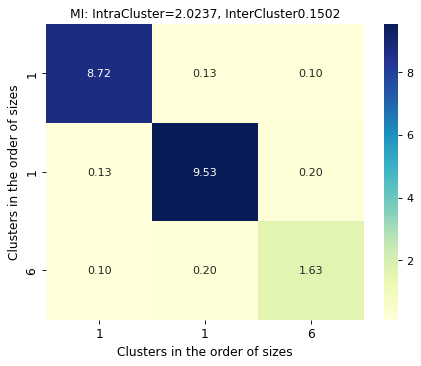

CPU times: user 8min 4s, sys: 22.2 s, total: 8min 26s
Wall time: 3.21 s


In [10]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
kmeans_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='kmeans')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, kmeans_cluster_labels)

# Spectral clustering

/a/stor125ncs2.virginia.ms.com/sc34972/s182224/venvs/senv/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


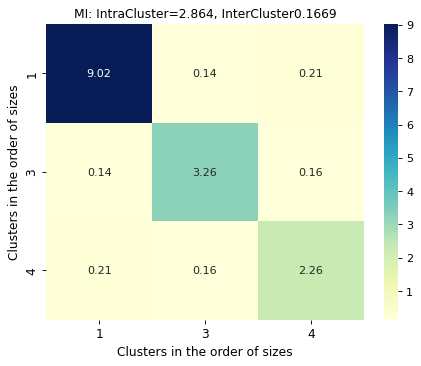

CPU times: user 262 ms, sys: 118 ms, total: 380 ms
Wall time: 189 ms


In [11]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
spectral_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='spectral')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, spectral_cluster_labels)

# ITC clustering via kNN (using the mutual information objective)

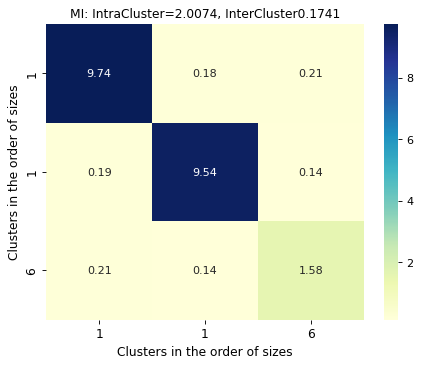

In [12]:
import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_knn_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_knn',
    data=data+1e-100*sampler.rand(data.shape[0], data.shape[1])
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_knn_cluster_labels)

# ITC clustering via minimum spanning tree (using the mutual information objective)

In [16]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_mst_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_mst',
    data=data,
    # data=data+1e-10*sampler.rand(data.shape[0], data.shape[1]),
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_mst_cluster_labels)

ValueError: not enough values to unpack (expected 3, got 2)

# Our ITC-DM approach with LSTMs

....................................................................................................Cluster Sizes [3 5]
....................................................................................................Cluster Sizes [3 2 3]
................

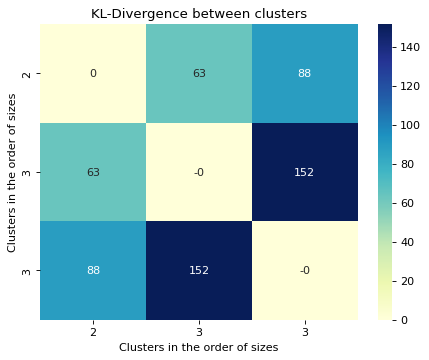

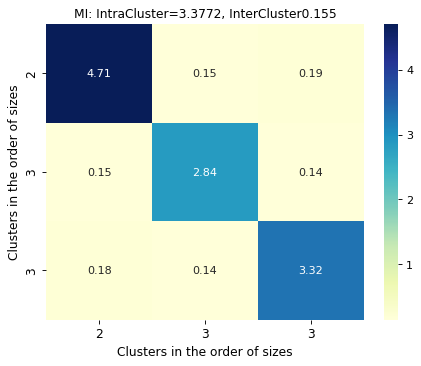

CPU times: user 8.36 s, sys: 1.14 s, total: 9.5 s
Wall time: 6.78 s


In [17]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_lstm = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    X_org=data.reshape(data.shape[0], 10, -1),
    num_layers=6,
    hidden_size=32,
    num_clusters=num_clusters,
    nn='lstm',
    device=device,
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 10, -1),
     c=cluster_labels_itc_dv_lstm,
     lr=1e-4,
     num_iter=1000,
     is_max_approx=True,
     std=0.1,
     num_layers=1,
     hidden_size=32,
     dropout=0.0,
     stop_on_zero_self_kl=True,
     device=device,
     debug=False,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_lstm)

# Our ITC-DM approach with Transformers

....................................................................................................Cluster Sizes [4 4]
....................................................................................................Cluster Sizes [2 4 2]
...............

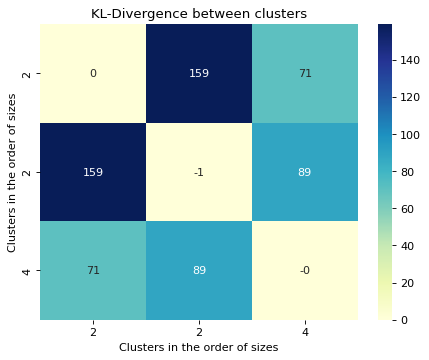

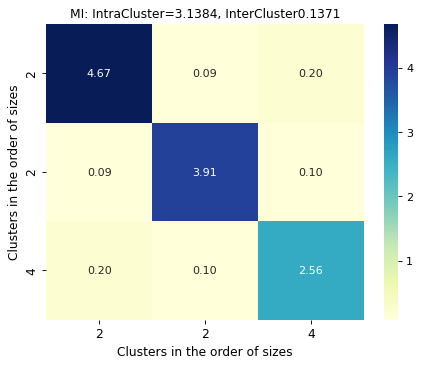

CPU times: user 23.1 s, sys: 782 ms, total: 23.9 s
Wall time: 13.7 s


In [18]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_transformer = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    X_org=data.reshape(data.shape[0], 10, -1),
    cluster_update_prob=1.0,
    num_layers=6,
    hidden_size=32,
    num_clusters=num_clusters,
    device=device,
    nn='transformer',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 10, -1),
     c=cluster_labels_itc_dv_transformer,
     num_layers=1,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_transformer)